---
title: "Identificando desastres en Twitter con NLP"
image: "disaster.jpeg"
sidebar:
    contents:
      - section: "First Section"
        contents:
          - href: seqclass-1-simple-nn.ipynb
author: "Diegulio"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [NLP, code, Kaggle]
---

# Goal 

I'm learning NLP. So to do that I decided pass trough diverse NLP models, study the teory and code them! 
I think that it is a good method to learn Machine Learning things. So, Disclaimer: All the content on the notebooks is what I understood from diverse references (I will put the links), somethings could be wrong, If you find any mistake please let me know, so I can learn of it. Also, if you have some doubt, it will be a pleasure to me to answer it (as long as I have the answer).

At the end, I achieve a score of 0.843 in the LB. Is beatifull to see how you are improving the solutions step by step!

So, this will be the embedding Notebook, I will put the link to each specific notebook here (So it will be more readable).

Methodologies & Notebooks:


|           Model Notebook          | Score |
|:-------------------------:|:-----:|
| [Simple Neural Network](seqclass-1-simple-nn.html) ( [View on kaggle](https://www.kaggle.com/code/diegomachado/seqclass-1-simple-nn-0-56))    | 0.56  |
| [Embeddings](seqclass-2-embeddings.html) ( [View on kaggle](https://www.kaggle.com/code/diegomachado/seqclass-2-embeddings-0-797))                | 0.797 |
| [Recurrent Neural Networks](seqclass-3-rnn.html) ( [View on kaggle](https://www.kaggle.com/code/diegomachado/seqclass-3-rnn-0-809/notebook)) | 0.809 |
| [BERT & HuggingFace](seqclass-4-bert-tensorflow-huggingface.html) ( [View on kaggle](https://www.kaggle.com/code/diegomachado/seqclass-4-bert-tensorflow-huggingface-0-824/notebook))        | 0.824 |
| [MyBestSolution](seqclass-5-mybestsolution.html) ( [View on kaggle](https://www.kaggle.com/code/diegomachado/seqclass-5-mybestsolution-0-843/notebook))            | 0.843 |


# EDA 
Here I will do some preprocessing and split the data. I will use that data to each notebook!

I think there is a lot of notebooks with a beatifull EDA, So I won't take to much around this.

### Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import gc


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Lambda
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow_hub as hub
#import tensorflow_text as text # Bert preprocess uses this 
from tensorflow.keras.optimizers import Adam

import re
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors

#nltk.download('stopwords')

### Data

In [2]:
train_df = pd.read_csv("../input/nlp-getting-started/train.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv("../input/nlp-getting-started/test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### EDA

<AxesSubplot:xlabel='target', ylabel='count'>

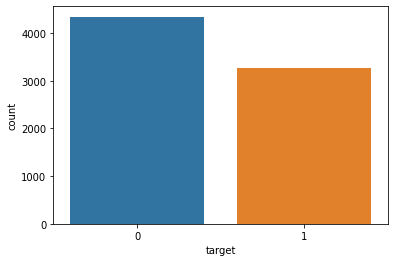

In [4]:
# Target Proportion
sns.countplot(data=train_df, x = "target")

I think it is balanced!

In [5]:
# Random example of disaster tweet
train_df[train_df.target == 1].sample(1).text.values[0]

'California Bush fires please evacuate affected areas ASAP when california govts advised you to do so http://t.co/ubVEVUuAch'

In [6]:
# Random example of NO disaster tweet
train_df[train_df.target == 0].sample(1).text.values[0]

'Someone split a mudslide w me when I get off work'

### Pre-processing

I will do some preprocessing with Tensorflow!

In [7]:
# Input Tensor Data
text = tf.data.Dataset.from_tensor_slices(train_df.text)
text

2022-12-11 15:20:58.687517: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<TensorSliceDataset shapes: (), types: tf.string>

Note that Im reading data from memory! If it would huge data I would be in troubles! 

One advantage of initialize a Tensorflow dataset is that I will be able to create a data pipeline (batch, fetch, shuffle, etc.)

In [8]:
# some samples
list(text.take(2).as_numpy_iterator())

[b'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 b'Forest fire near La Ronge Sask. Canada']

We need to know that models don't understand text by itself! Just numbers! For this, we vectorize the sentences. I don't plan to use a model now, I would like to observe wich words are more present by target! (Also I don't want to consider **stopwords**) 

I will use the tensorflow layer: Text Vectorization. from behind, it apply lowercase and delete punctuation. I also wants to remove stopwords, so I will build a custom standarization that do: 
1. lowercase
2. strip punctuation
3. remove stop words! 

[Click here if you don't know what are stop words](https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/)

In [9]:
#### COUNT WORDS BY TARGET

def custom_standardization(inputs):
    """
    Apply: lowercase, remove punctuation and stopwords
    """
    PUNCTUATION = r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']'
    lowercase = tf.strings.lower(inputs) # lowercase
    strip = tf.strings.regex_replace(lowercase, PUNCTUATION, '') # strip punctuation
    stopwrd = tf.strings.regex_replace(strip, r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', '')
    return stopwrd
    

# model to apply vectorize_layer with custom standardization
vectorize_layer = tf.keras.layers.TextVectorization(output_mode = 'multi_hot', standardize = custom_standardization)
vectorize_layer.adapt(text)

# model to vectorize
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# make counter
train_count = model.predict(text.batch(batch_size = len(text))) # predict to count 
token_counts = pd.DataFrame(columns = vectorize_layer.get_vocabulary(), data = train_count) # df with tokens and count
train_df.rename(columns = {"target":"disaster_target"}, inplace = True) # rename target because there is a word target in data
count_df = pd.concat([train_df, token_counts], axis = 1) #concat
group_count = count_df.iloc[:,4:].groupby("disaster_target", as_index = False).sum() # count token for each target
melt_count = pd.melt(group_count, id_vars=["disaster_target"], value_name = "count") # each token to row
melt_count.sort_values(by=["count"], ascending = False).head(30)

2022-12-11 15:20:58.997911: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,disaster_target,variable,count
2,0,like,239.0
4,0,im,221.0
6,0,amp,174.0
12,0,new,163.0
9,1,fire,162.0
10,0,get,158.0
22,0,dont,136.0
21,1,news,130.0
18,0,one,122.0
15,1,via,121.0


After I build it I realized that it is not necessary to instantiate a model to use layers! 😅

# Split Data

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_df[[col for col in train_df.columns if col != 'disaster_target']], train_df.disaster_target, test_size=0.2, random_state=13)

In [12]:
# To csv (In some notebooks I will use this data)
pd.concat([X_train, y_train], axis = 1).to_csv('df_train.csv',index = False)
pd.concat([X_test, y_test], axis = 1).to_csv('df_test.csv',index = False)

This dataset is here: https://www.kaggle.com/datasets/diegomachado/df-split

In [13]:
# Delete it from memory
del train_df, test_df, X_train, X_test, y_train, y_test
gc.collect()

671